# YouTube trending videos

In [6]:
%matplotlib inline
import json
import math
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from imgprocessing.image_size import ImageSize
from tokenizers import Tokenizer

from nltk.corpus import words as nltk_words
import nltk
nltk.download("words")


def autolabel(rects, labels):
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                labels[idx],
                ha='center', va='bottom', rotation=0)


def filter_words(row):
    if not isinstance(row["words"], str):
        print(row)
    if row["words"] in nltk_words.words():
        return True
    return False


def tokenize(csv_path:str, df, json_path:str):
    ocr_text_nan_count = 0
    if os.path.exists(csv_path):
        words = pd.read_csv(csv_path, sep=";")
        words = words["words"].to_frame()
        with open(json_path, "r") as file:
            tokenized_titles = json.load(file)
            file.close()
        for i in tqdm(tokenized_titles):
            if not i:
                ocr_text_nan_count += 1
    else:
        words = pd.DataFrame()
        tokenized_titles = []
        for i in tqdm(range(len(df))):
            text = df["ocr_texts"].iloc[i]
            if isinstance(text, str):
                tokens = Tokenizer.tokenize(text)
                tokenized_titles.append(tokens)
                words = words.append(pd.DataFrame(data={"words": Tokenizer.tokenize(df["ocr_texts"].iloc[i])}), ignore_index=True)
            elif isinstance(text, float):
                if math.isnan(text):
                    ocr_text_nan_count += 1
                    tokenized_titles.append([])
            else:
                print(text, type(text))
                tokenized_titles.append([])
        words.to_csv(csv_path, sep=";")
        with open(json_path, "w") as file:
            json.dump(tokenized_titles, file)
            file.close()
    print(len(tokenized_titles))
    print(f"Nan: {ocr_text_nan_count}")
    words_counts = words.value_counts()
    words_counts = words_counts.rename_axis("words").reset_index(name="count")
    print(words_counts)
    return words_counts



[nltk_data] Downloading package words to /home/michal/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Etap 2 - Atrybuty wizualne


W celu zmniejszenia kosztów obliczeniowych, a także rozmiaru zbioru zdjęć zbiór
danych poddano wstępnej obróbce, która obejmowała:
- ekstrakcję brakujących identyfikatorów filmów z linku do obrazka,
- grupowanie filmów po nowo utworzonym identyfikatorze z zachowaniem tylko
unikalnych linków do obrazów.


In [7]:
data_path = "youtube_grouped_by_id_all_list"
gb_videos = pd.read_csv(os.path.join(data_path, "GB_videos_5p.csv"), sep=";", index_col=0)
us_videos = pd.read_csv(os.path.join(data_path, "US_videos_5p.csv"), sep=";", index_col=0)
videos = pd.concat([gb_videos, us_videos])
videos = videos.rename(columns={"description ":"description"})
videos.head(10)

size = ImageSize.hqdefault.default
images_path = os.path.join("images")
gb_images = pd.read_csv(os.path.join(images_path, f"GB_{size}.csv"), sep=";", index_col=0)
us_images = pd.read_csv(os.path.join(images_path, f"US_{size}.csv"), sep=";", index_col=0)

videos_images = pd.concat([gb_images, us_images])
videos_images = videos_images.rename(columns={"description ":"description"})
videos_images.head(10)


,number,id,count,thumbnail_path,error,status
0,0,--uXQQ0h-yQ,9,['images/default/0_GB_--uXQQ0h-yQ_0.jpg'],[False],[200]
0,1,-3VBPAZPTQI,14,['images/default/1_GB_-3VBPAZPTQI_0.jpg'],[False],[200]
0,2,-43MBOJnVks,2,['images/default/2_GB_-43MBOJnVks_0.jpg'],[False],[200]
0,3,-5WBCrazSfg,10,['images/default/3_GB_-5WBCrazSfg_0.jpg'],[False],[200]
0,4,-5aaJJQFvOg,34,['images/default/4_GB_-5aaJJQFvOg_0.jpg'],[False],[200]
0,5,-7tSTUR7FG0,15,['images/default/5_GB_-7tSTUR7FG0_0.jpg'],[False],[200]
0,6,-8X32zNup1o,9,['ERROR'],[True],[404]
0,7,-A9rYcBmBFo,9,['images/default/7_GB_-A9rYcBmBFo_0.jpg'],[False],[200]
0,8,-B7J36GNaDk,6,['images/default/8_GB_-B7J36GNaDk_0.jpg'],[False],[200]
0,9,-BDImdAfodA,32,['images/default/9_GB_-BDImdAfodA_0.jpg'],[False],[200]


## Najczęściej występujące obrazy

**Wielka Brytania**

Poniżej przedstawione jest 10 najczęściej występujących obrazów w zbiorze
z Wielkiej Brytanii i Stanów Zjednoczonych.

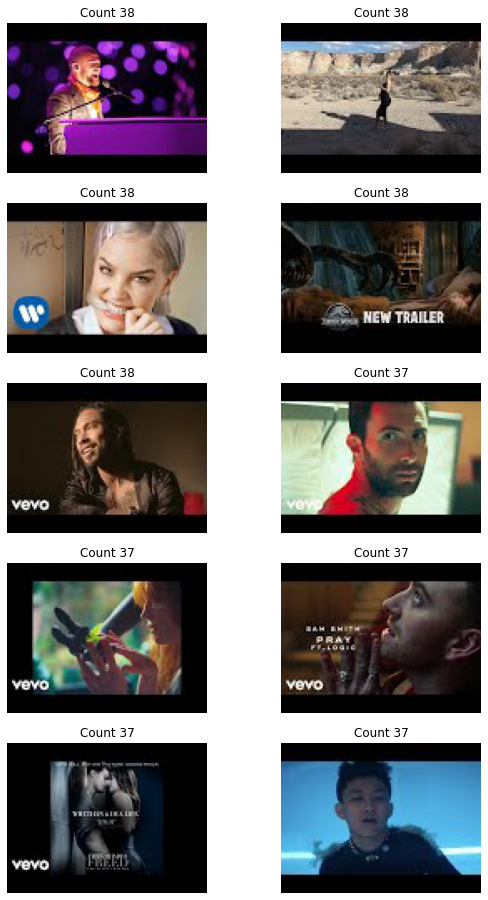

In [42]:
n_top = 10
columns = 2

gb_top = gb_images.nlargest(n_top, "count")

fig, axs = plt.subplots(n_top // columns, columns,figsize=(9,16)) # , gridspec_kw={'height_ratios': [1, 2]}
for i in range(n_top // 2):
    for j in range(columns):
        index = i * columns + j
        image_path = eval(gb_top["thumbnail_path"].iloc[index])[0]
        count = gb_top["count"].iloc[index]
        image = mpimg.imread(image_path)
        axs[i][j].title.set_text(f"Count {count}")
        axs[i][j].axis('off')
        axs[i][j].imshow(image)

**Stany Zjednoczone**

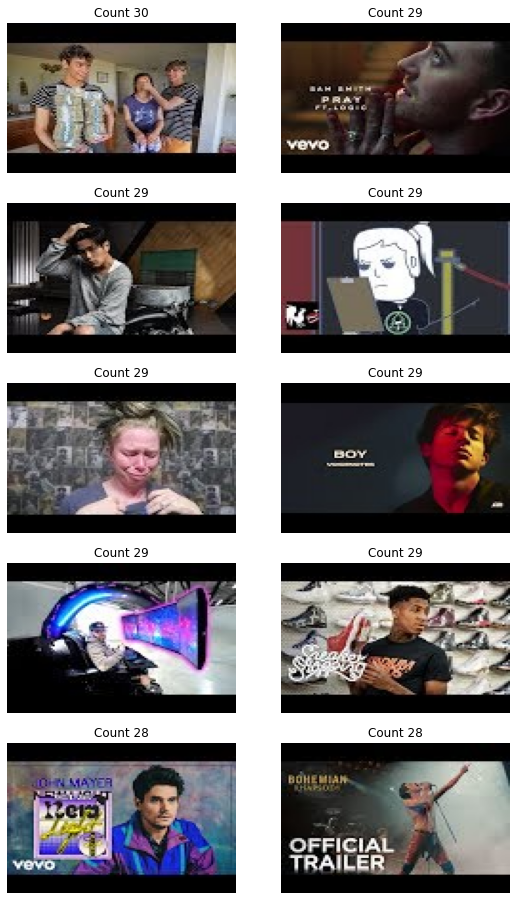

In [281]:
us_top = us_images.nlargest(n_top, "count")

fig, axs = plt.subplots(n_top // columns, columns,figsize=(9,16)) # , gridspec_kw={'height_ratios': [1, 2]}
for i in range(n_top // 2):
    for j in range(columns):
        index = i * columns + j
        image_path = eval(us_top["thumbnail_path"].iloc[index])[0]
        count = us_top["count"].iloc[index]
        image = mpimg.imread(image_path)
        axs[i][j].title.set_text(f"Count {count}")
        axs[i][j].axis('off')
        axs[i][j].imshow(image, aspect='auto')


### Wczytanie zbioru wygenerowanych cech

Istniejące zbiory danych zostały rozszerzone o dodatkowe cechy:
- lista obiektów znajdujących się na obrazie wraz z wartością *score*,
- nazwy emocji pojawiających się na twarzach ludzi z obrazów,
- teksty znajdujące się na obrazach uzyskane przy pomocy narzędzia ocr,
- 5 najczęściej występujących kolorów na obrazie.

In [8]:
data_path = "images_data"

gb_data = pd.read_csv(os.path.join(data_path, f"GB_images_data.csv"), sep=";", index_col=0)
us_data = pd.read_csv(os.path.join(data_path, f"US_images_data.csv"), sep=";", index_col=0)
eval_columns = ["error", "status", "obj_names", "obj_scores", "emotions", "colors"]

for df in [gb_data, us_data]:
    for c in eval_columns:
        df[c] = df[c].apply(lambda x: eval(x))

### Rozkład sukcesu pobrania obrazu

Na wykresach poniżej znajdują się:
- liczba poprawnie pobranych obrazów,
- liczba pobrań, podczas których pojawił się błąd.

In [283]:
for df in [gb_data, us_data]:
    df["unique_count"] = df["error"].apply(lambda x: len(x))
    df["ok_count"] = df["error"].apply(lambda x: x.count(False))
    df["error_count"] = df["error"].apply(lambda x: x.count(True))

videos_data = pd.concat([gb_data, us_data])

,number,id,count,thumbnail_path,error,status,obj_names,obj_scores,ocr_texts,emotions,colors,unique_count,ok_count,error_count
0,0,--uXQQ0h-yQ,9,['ERROR'],[True],[404],[],[],NaN,[],[],1,0,1
0,1,-3VBPAZPTQI,14,['images\\maxresdefault\\1_GB_-3VBPAZPTQI_0.jpg'],[False],[200],"[person, person]","[0.9412501, 0.8961376]",\r\n\r\n \r\n,[happy],"[([(175, 95, 95), IndianRed], 7588.0), ([(175,...",1,1,0
0,2,-43MBOJnVks,2,['images\\maxresdefault\\2_GB_-43MBOJnVks_0.jpg'],[False],[200],[person],[0.82978743],\r\n,[],"[([(108, 108, 108), Grey42], 8845.0), ([(118, ...",1,1,0
0,3,-5WBCrazSfg,10,['images\\maxresdefault\\3_GB_-5WBCrazSfg_0.jpg'],[False],[200],[person],[0.8106267],\r\n\r\n \r\n\r\nDREAM 5A SIDE\r\n,[happy],"[([(8, 8, 8), Grey3], 9019.0), ([(18, 18, 18),...",1,1,0
0,4,-5aaJJQFvOg,34,['images\\maxresdefault\\4_GB_-5aaJJQFvOg_0.jpg'],[False],[200],"[person, person, person, person, person, tie, ...","[0.8760423, 0.72684914, 0.66787523, 0.63907856...",\r\n,"[neutral, sad, happy, happy, happy]","[([(18, 18, 18), Grey7], 4862.0), ([(28, 28, 2...",1,1,0
0,5,-7tSTUR7FG0,15,['images\\maxresdefault\\5_GB_-7tSTUR7FG0_0.jpg'],[False],[200],"[person, person, person, person, person]","[0.9571229, 0.92626053, 0.91444457, 0.8616719,...",\r\n,[],"[([(158, 158, 158), Grey62], 8439.0), ([(148, ...",1,1,0
0,6,-8X32zNup1o,9,['ERROR'],[True],[404],[],[],NaN,[],[],1,0,1
0,7,-A9rYcBmBFo,9,['images\\maxresdefault\\7_GB_-A9rYcBmBFo_0.jpg'],[False],[200],[],[],\r\n,"[angry, fear]","[([(18, 18, 18), Grey7], 7234.0), ([(8, 8, 8),...",1,1,0
0,8,-B7J36GNaDk,6,['images\\maxresdefault\\8_GB_-B7J36GNaDk_0.jpg'],[False],[200],[],[],\r\n,[],"[([(175, 215, 215), LightCyan3], 7542.0), ([(2...",1,1,0
0,9,-BDImdAfodA,32,['images\\maxresdefault\\9_GB_-BDImdAfodA_0.jpg'],[False],[200],[person],[0.90380037],\r\n,[happy],"[([(28, 28, 28), Grey11], 4443.0), ([(38, 38, ...",1,1,0


**Wielka brytania**

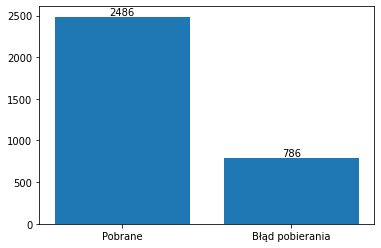

In [185]:
heights = [gb_data["ok_count"].sum(axis=0), gb_data["error_count"].sum(axis=0)]
bars = plt.bar([0, 1], heights)
autolabel(bars, heights)
plt.xticks([0, 1], ["Pobrane", "Błąd pobierania"])
plt.show()

**Stany Zjednoczone**

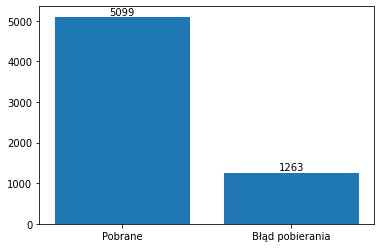

In [186]:
heights = [us_data["ok_count"].sum(axis=0), us_data["error_count"].sum(axis=0)]
bars = plt.bar([0, 1], heights)
autolabel(bars, heights)
plt.xticks([0, 1], ["Pobrane", "Błąd pobierania"])
plt.show()

**Razem**

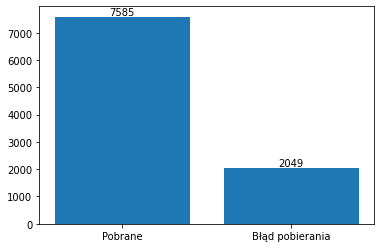

In [187]:
heights = [videos_data["ok_count"].sum(axis=0), videos_data["error_count"].sum(axis=0)]
bars = plt.bar([0, 1], heights)
autolabel(bars, heights)
plt.xticks([0, 1], ["Pobrane", "Błąd pobierania"])
plt.show()

## Średnie kolorów

Analizy samych thumbnaily pod względem statystycznym dokonywane były na ich najmniejszej rozdzielczości (120x90), aby zmniejszyć koszty obliczeniowe, jednak taka ponieważ jest to mocno uśredniane wyniki, nie wydaje się żeby rozdzielczość była problemem. Dodatkowo obrazki miały czarne paski o szerokości 11 pikseli u góry i dołu - te paski były usuwane, ponieważ znacząco zniekształcały wyniki analiz. Każda z analiz wykonywana była osobno dla Wielkiej Brytanii, Stanów Zjednoczonych jak i zbioriwej analizy.

In [47]:
import cv2
import numpy as np

def calculate(d, mode):
    grays = []
    colors = []
    hsvs = []
    imgs = []
    
    data = gb_images
    data = gb_images if d == 'gb' else data
    data = us_images if d == 'us' else data
    data = videos_images if d == 'all' else data
    
    for index in range(data.shape[0]):
        if not eval(data["error"].iloc[index])[0]:
            image_path = eval(data["thumbnail_path"].iloc[index])[0]
            img = cv2.imread(image_path)
            if img.shape[:2] != (90,120): continue
            img = img[11:-11,:]
            
            #średnie
            if mode == 'colors':
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                grays.append(gray)
                colors.append([img[:,:,0],img[:,:,1],img[:,:,2]])
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                hsvs.append([hsv[:,:,0],hsv[:,:,1],hsv[:,:,2]])
            
            #hist
            if mode == "hist":
                g,c = get_hist(img)
                grays.append(g)
                colors.append(c)
            
            # edges
            if mode == "edges":
                edges = cv2.Canny(img,100,200)
                imgs.append(edges)
            
            #entropy
            if mode == "entropy":
                img = calc_entropy(img)
                imgs.append(img)
            
    if mode == 'colors': return grays, colors, hsvs
    elif mode == 'hist': return grays, colors
    else: return imgs

In [10]:
def plot_two(plot1, t1, plot2, t2, cmap = 'viridis'):
    fig, axs = plt.subplots(1,2,figsize=(16,9))
    axs[0].imshow(plot1, cmap = cmap)
    axs[0].title.set_text(t1)
    axs[1].imshow(plot2, cmap = cmap)
    axs[1].title.set_text(t2)
    plt.show()

In [25]:
def connect_channels(channels):
    img_new = np.zeros((68,120,3),np.uint8)
    img_new[:,:,0] = channels[0]
    img_new[:,:,1] = channels[1]
    img_new[:,:,2] = channels[2]
    return img_new

Pierwszą z tych analiz jest analiza samcyh wartości obrazków i kolorów w zarówno przestrzeni RGB, jak i HSV. Liczone były średnie oraz mediany dla wszystkich obrazków.

In [57]:
def col_analysis(d):
    grays, colors, hsvs = calculate(d,'colors')
    
    gray_mean = np.mean(grays, axis = 0)
    gray_med = np.median(grays, axis = 0)

    color = list(zip(*colors))
    color_mean = [np.mean(x, axis = 0) for x in color]
    color_median = [np.median(x, axis = 0) for x in color]
    
    color_new = connect_channels(color_mean)
    color_new2 = connect_channels(color_median)
    
    hsv = list(zip(*hsvs))
    hsv_mean = [np.mean(x, axis = 0) for x in hsv]
    hsv_median = [np.median(x, axis = 0) for x in hsv]
    
    hsv_new = connect_channels(hsv_mean)
    hsv_new2 = connect_channels(hsv_median)
    
    means = [np.mean(x) for x in color_mean]
    print("Średnie RGB: ",list(zip(['R: ', 'G: ','B: '],means)))
    medians = [np.median(x) for x in color_median]
    print("Mediany RGB: ",list(zip(['R: ', 'G: ','B: '],medians)))

    hmeans = [np.mean(x) for x in hsv_mean]
    print("Średnie HSV: ",list(zip(['H: ', 'S: ','V: '],hmeans)))
    hmedians = [np.median(x) for x in hsv_median]
    print("Mediany HSV: ",list(zip(['H: ', 'S: ','V: '],hmedians)))
    
    plot_two(gray_mean, 'Grayscale mean', gray_med, 'Grayscale median', 'gray')
    plot_two(color_new, 'RGB mean', color_new2, 'RGB median')
    plot_two(hsv_new, 'HSV mean', hsv_new2, 'HSV median')

**Wielka brytania**

Średnie RGB:  [('R: ', 97.58064755600051), ('G: ', 97.99854162835679), ('B: ', 109.00887903615771)]
Mediany RGB:  [('R: ', 83.0), ('G: ', 84.0), ('B: ', 98.0)]
Średnie HSV:  [('H: ', 68.28098821588378), ('S: ', 94.88652458812633), ('V: ', 121.39124364056148)]
Mediany HSV:  [('H: ', 56.0), ('S: ', 79.0), ('V: ', 118.0)]


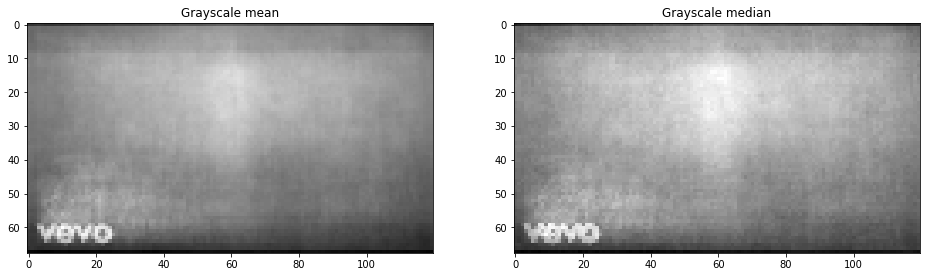

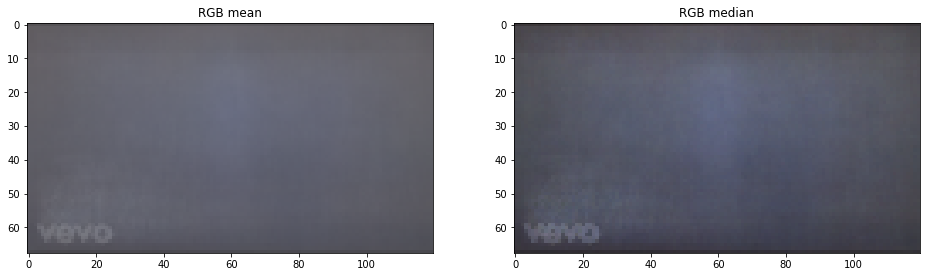

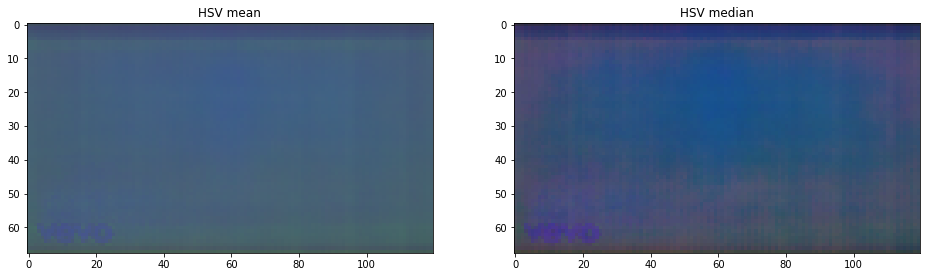

In [58]:
col_analysis('gb')

**Stany Zjednoczone**

Średnie RGB:  [('R: ', 104.0766614360688), ('G: ', 106.44561825583185), ('B: ', 118.40457426445502)]
Mediany RGB:  [('R: ', 91.0), ('G: ', 97.0), ('B: ', 113.0)]
Średnie HSV:  [('H: ', 65.566895311946), ('S: ', 92.60148242084279), ('V: ', 130.67865811541267)]
Mediany HSV:  [('H: ', 40.0), ('S: ', 76.0), ('V: ', 131.0)]


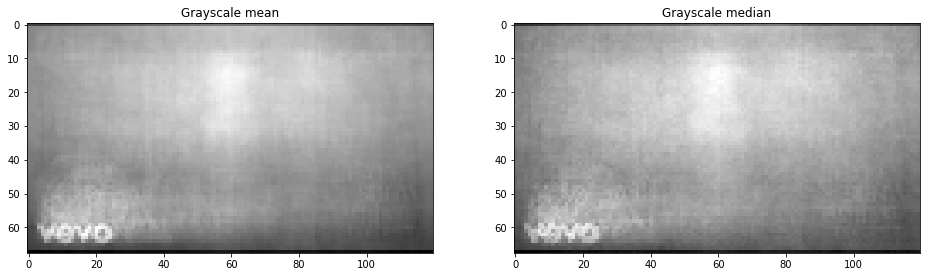

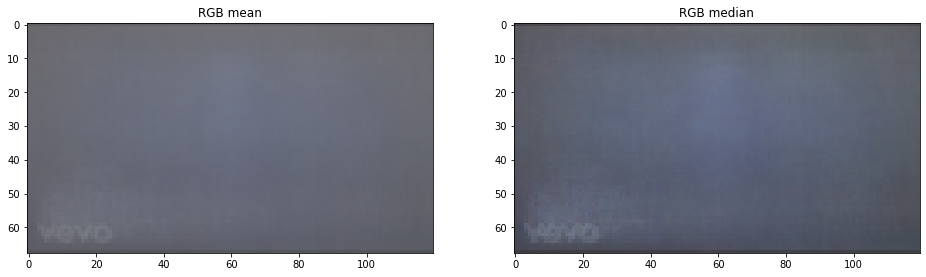

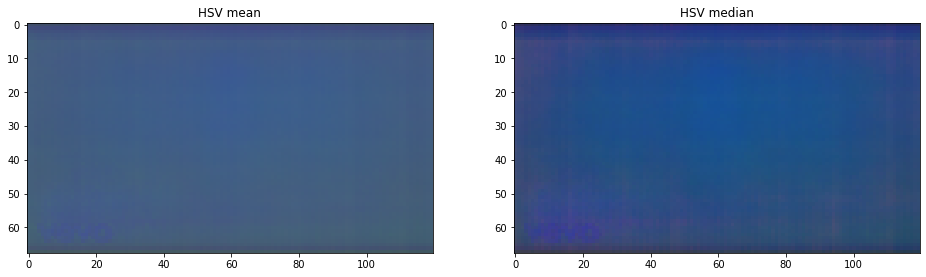

In [43]:
col_analysis('us')

**Razem**

Średnie RGB:  [('R: ', 101.9370865635466), ('G: ', 103.66342701792992), ('B: ', 115.30993903252869)]
Mediany RGB:  [('R: ', 88.5), ('G: ', 93.0), ('B: ', 108.0)]
Średnie HSV:  [('H: ', 66.4608288973981), ('S: ', 93.35410070245922), ('V: ', 127.61968702822624)]
Mediany HSV:  [('H: ', 44.0), ('S: ', 77.0), ('V: ', 127.0)]


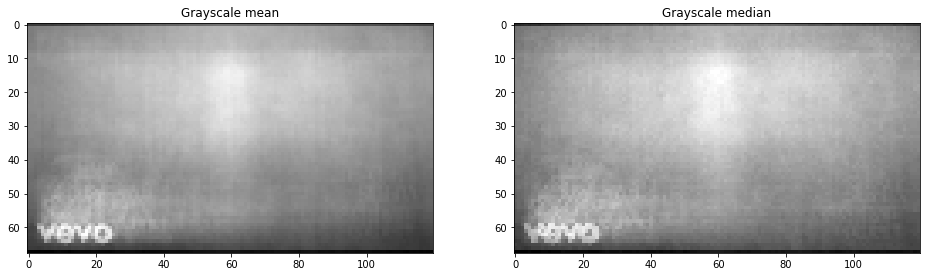

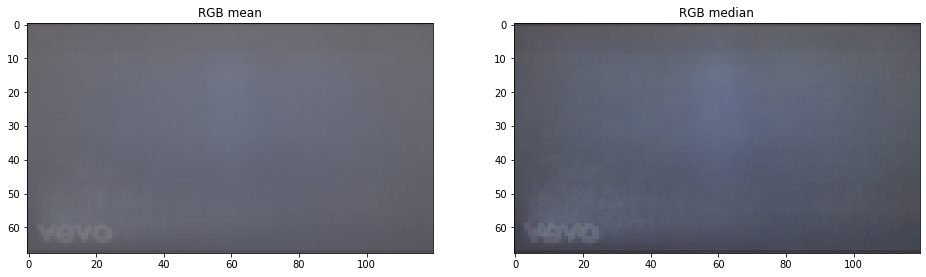

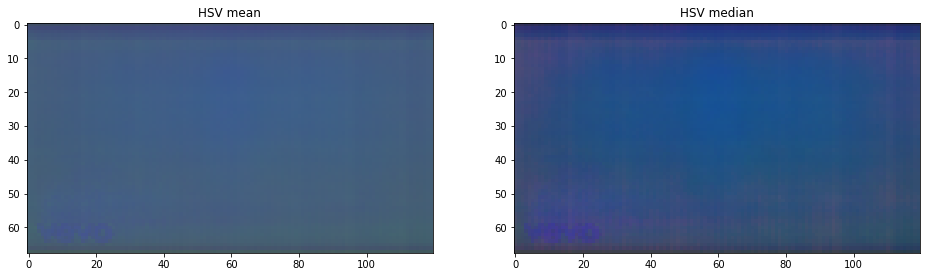

In [44]:
col_analysis('all')

Patrząc na wyniki liczbowe można zauważyć lekką przewagę koloru niebieskiego, szczególnie w danych US. Ogólnie amerykańskie filmiki zdają się mieć na ogół **jaśniejsze kolory**, mimo że to te z Wielkiej Brytanii mają odrobiną większą średnią saturacje.

Analizując wyniki obrazkowe, nie widać zbytnio różnicy między lokalizajcami. W wynikacj grayscale najlepiej widać że na obrazkach widać znak wodny firmy **"vevo"** (lekko wyraźniejsze w GB), która zajmuje się kanałami z muzyką największych gwiazd świata muzyki, co pokazuje tylko jak popularne (z jednolicie umieszczanonymi znaki wodnymi) są teledyski na YT. Sam lewy dolny róg zdaje się być trochę jaśniejszy co może sugerować że często umieszczane są tam też inne znaki wodne.

Środki obrazków są odrobinę jaśniejsze, a w samym środku można zauważyć jaśniejszą plamę w kształcie przymominającym **sylwetkę człowieka**.

Obrazki kolorowe, a w szczególności patrząc na mediany i to najlepiej HSV, widać wcześniej wymienioną **dominacje koloru niebieskiego.**


## Histogramy

Dokonano analizy histogramu kolorów osobno dla obrazu grayscale oraz dla trzech kanałów koloru.

In [11]:
def get_hist(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist_gray = cv2.calcHist([gray],[0],None,[256],[0,256])
    hists = []
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        hists.append(histr)  
    return hist_gray, hists
    
    
def draw_hist(hist1,t1, hist2,t2, color=True):
    fig, axs = plt.subplots(1,2,figsize=(16,5))
    if not color:
        axs[0].plot(hist1)
        axs[1].plot(hist2)
    else:
        for hst,col in zip(hist1, ('b','g','r')):
            axs[0].plot(hst,color = col)
        for hst,col in zip(hist2, ('b','g','r')):
            axs[1].plot(hst,color = col)
    axs[0].title.set_text(t1)
    axs[1].title.set_text(t2)
    plt.xlim([-10,266])
    plt.show()


In [12]:
def histogram(d):
    grays, colors = calculate(d,'hist')

    gray_mean = np.mean(grays, axis = 0)
    gray_med = np.median(grays, axis = 0)
    colors = list(zip(*colors))
    color_mean = [np.mean(x, axis = 0) for x in colors]
    color_median = [np.median(x, axis = 0) for x in colors]

    draw_hist(gray_mean,'Grayscale mean',gray_med, 'Grayscale median',False)
    draw_hist(color_mean,'Color mean',color_median,'Color median',True)

**Wielka brytania**

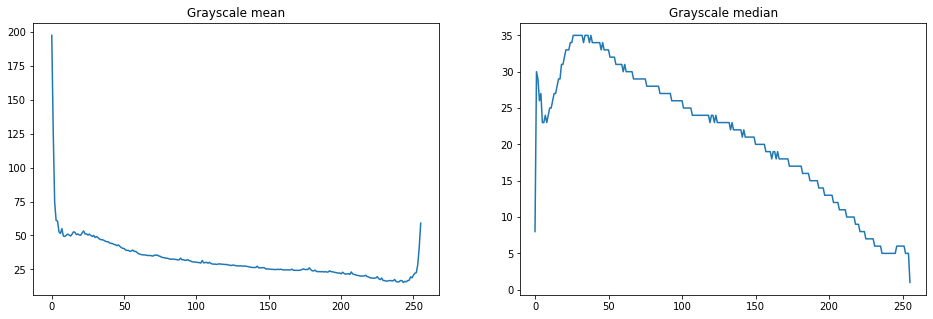

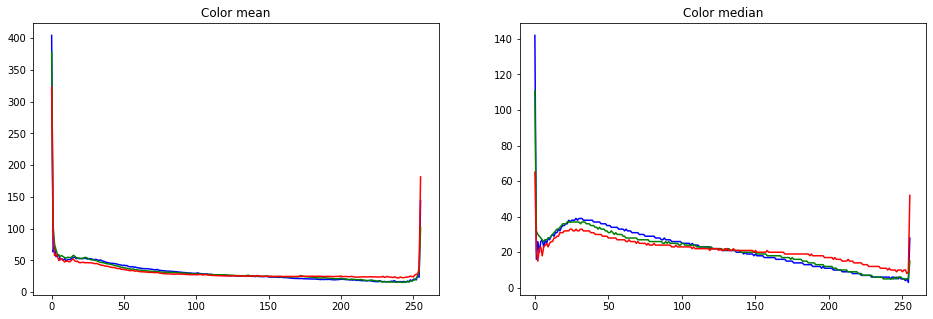

In [13]:
histogram('gb')

**Stany Zjednoczone**

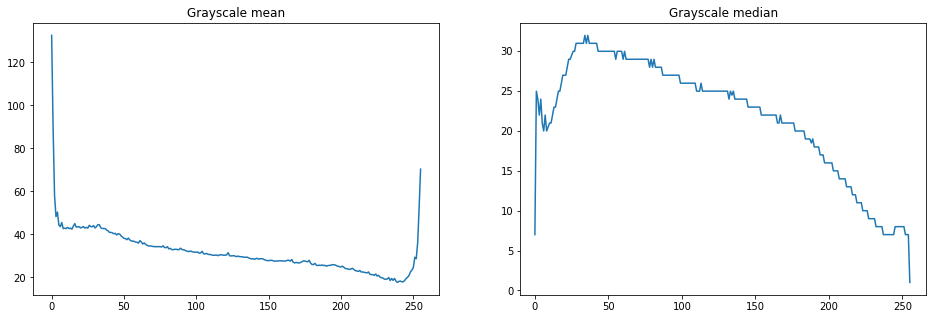

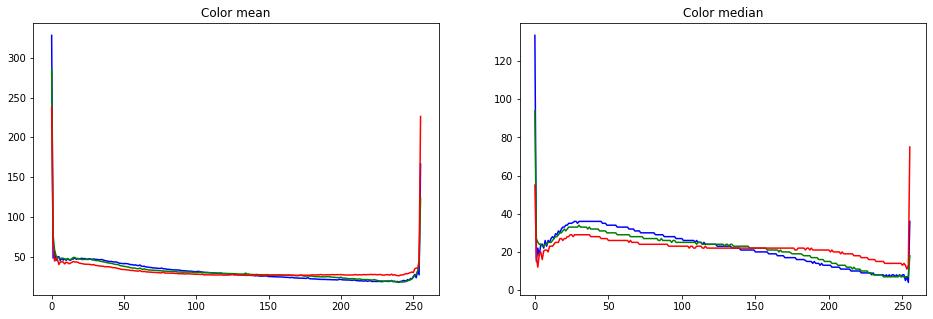

In [15]:
histogram('us')

**Razem**

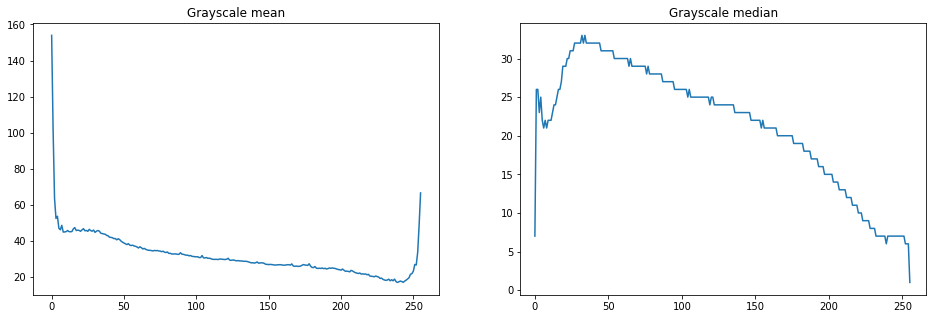

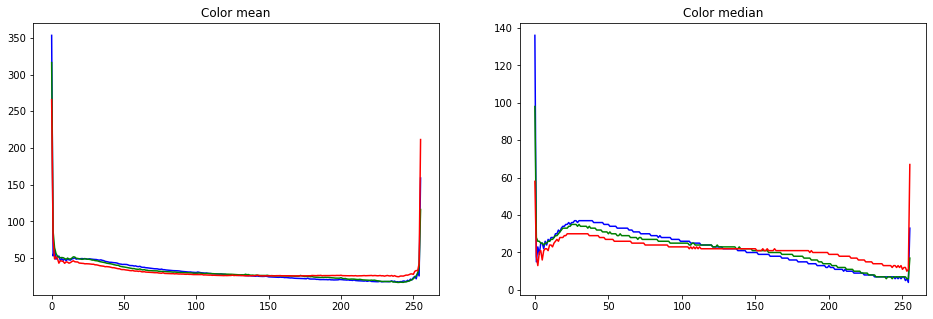

In [16]:
histogram("all")

Wykresy dla obydwu rejonów wyglądają podobnie odrobinę więcej zieleni oraz czerwieni.
Te dla odcieni szarości pokazują że w obrazkach występuje zaskakująci dużo bardzo ciemnych kolorów oraz dużo bieli, jednak wykres mediany pokazuje że **dominującym odcieniem jest ciemny szary** w okolicach 50 na 255.

Patrząc na wykresy kolorowe można zauważyć bardzo podobny rozkład dla każdego z trzech kanałów, z kolorem **niebieskim najczęściej będącym w niskich wartoścach** a **kolorem czerwonym najczęściej w jasnych i wyraźistych** (być może jest kolorem najlepiej przyciągającym uwagę w dużej intensywności)

## Entropia

Kolejną analizą jest kalkulacja średniej entropii w obrazkach, co pokazuje w jakich obszarach występują najbardziej zmienne kolorystycznie elementy. Entropia liczona jest dla każdego piksela (w obrazie grayscale) w stosunku do jego okolicy 3x3. Zaprezentowana jest zarówno średnia jak i mediana wartości entropii dla każdego z rejonów.

In [17]:
def entropy(signal):
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent
    
    
def layer_entropy(img,N=5):
    S=img.shape
    E=np.array(img)
    for row in range(S[0]):
          for col in range(S[1]):
            Lx=np.max([0,col-N])
            Ux=np.min([S[1],col+N])
            Ly=np.max([0,row-N])
            Uy=np.min([S[0],row+N])
            region=img[Ly:Uy,Lx:Ux].flatten()
            E[row,col]=entropy(region)
    return E

In [18]:
def calc_entropy(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scale = 0.3
    img = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
    img = layer_entropy(img,3)
    
    return img
    
def show_entropy(img,t1,img2,t2):
    fig, axs = plt.subplots(1,2,figsize=(16,5))
    im1 = axs[0].imshow(img, cmap=plt.cm.jet)
    fig.colorbar(im1,ax=axs[0], shrink=0.6)
    im2 = axs[1].imshow(img2, cmap=plt.cm.jet)
    fig.colorbar(im2,ax=axs[1], shrink=0.6)
    axs[0].title.set_text(t1)
    axs[1].title.set_text(t2)
    
    plt.show()

In [19]:
def ent(d):
    imgs = calculate(d,'entropy')
    img_mean = np.mean(imgs, axis = 0)
    img_med = np.median(imgs, axis = 0)
    
    show_entropy(img_mean,"Mean entropy", img_med, "Median entropy")

**Wielka brytania**

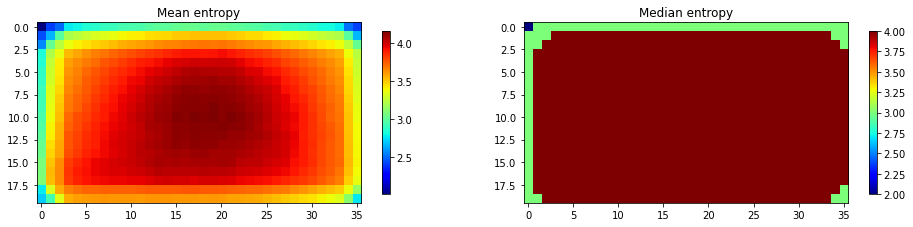

In [20]:
ent('gb')

**Stany Zjednoczone**

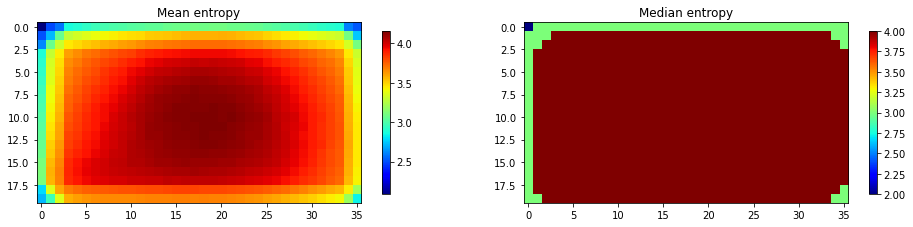

In [45]:
ent('us')

**Razem**

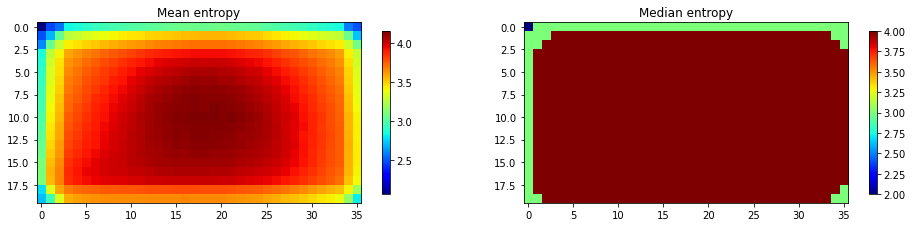

In [46]:
ent('all')

Istnieje bardzo małą różnicę między filmami z różnych rejonów, co może sugerować że są one dosyć dobrze uogólniane.

To co widać na pierwszy rzut oka, to to że entropia jest wyraźnie największa na środku i stopniowo maleje wraz z oddalaniem się do brzegów. Znaczy to że najbardziej złożone i zróżnicowane kolorowo obiekty znajdują się w **pozycji centralnej**. Widać też że entropia jest **mniejsza na górnej krawędzi niż na dolnej**, co sugeruje że częściej pewne elementy (np. napisy) umieszczane są częściej na dole.

Miejscem o najmniejszej entropii jest lewy górny róg, mimo że w bardziej środkowej części obrazka entropia jest odbrobinę większa po lewej stronie (może to być przykładowo spowodowane znakami wodnymi, takimi jak bardzo popularny znak "vevo")

## Wykrywanie krawędzi filtrem Canny

Analizowane były również krawędzie na obrazkach wykryte za pomocą filtru Canny. Wyniki zostały potem uśrednione.

In [21]:
def canny(d):
    lines = calculate(d,'edges')
    edges_mean = np.mean(lines, axis = 0)
    plt.imshow(edges_mean, 'gray')
    plt.show()

**Wielka brytania**

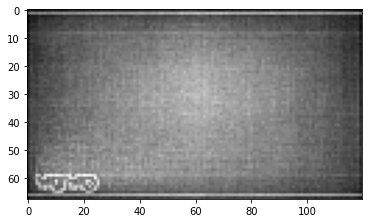

In [22]:
canny('gb')

**Stany Zjednoczone**

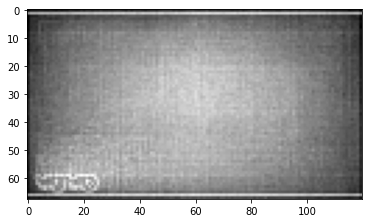

In [23]:
canny('us')

**Razem**

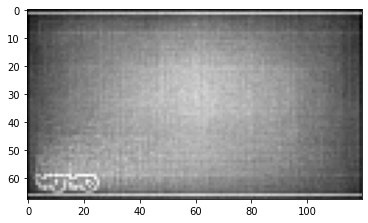

In [24]:
canny('all')

Z powodu tak dużej ilości skumulowanych obrazów i tym samym olbrzymiej ilości krawędzi, powstał szarawy obraz, na którym jedyne widoczne krawędzie to te w okół napisu "vevo" oraz horyzntalne linie na górze i dole obrazków. To co można zauważyć to zdecydowanie **większa liczba krawędzi w centralnej części obrazu**, co jest zgodne z wynikami kalkulacji entropii o większej złozoności tego obszaru.

Widać tutaj również **jaśniejszy obraz dla rejonu US niż GB**, co znaczy że te obrazy zasadniczo więcej krawędzi, czyli potencjalnie obiektów w kadrze.

### Wykrywanie obiektów na obrazach


Poniższe tabele i wykresy odnoszą się do liczności pojawiających się
na obrazach klas ze zbioru COCO. Wykresy przedstawiają 50 najczęściej występujących
klas. Dla czytelności wykresów została pominięta najbardziej liczna klasa
**person** jej wystąpienia można odczytać z wyjścia programów zawartych
w poszczególnych komórkach.

Podczas wykrywania obiektów, brano pod uwagę tylko obiekty, które
zostały rozpoznane z pewnością większą niż 0.5.


**Wielka brytania**

In [188]:
gb_objects = gb_data["obj_names"].apply(pd.Series, 1).stack()
gb_objects.index = gb_objects.index.droplevel(-1)
gb_objects.name = "obj_name"

gb_objects = gb_objects.to_frame()
unique_gb_objects = gb_objects["obj_name"].value_counts() #
unique_gb_objects = unique_gb_objects.rename_axis("obj_name").reset_index(name="count")
unique_gb_objects.describe()

,count
count,62.000000
mean,65.064516
std,412.210430
min,1.000000
25%,2.000000
50%,5.000000
75%,14.000000
max,3254.000000


     obj_name  count
0      person   3254
1         tie    144
2         cup     56
3       chair     55
4        vase     46
..        ...    ...
57      bench      1
58       sink      1
59    giraffe      1
60  microwave      1
61      mouse      1

[62 rows x 2 columns]


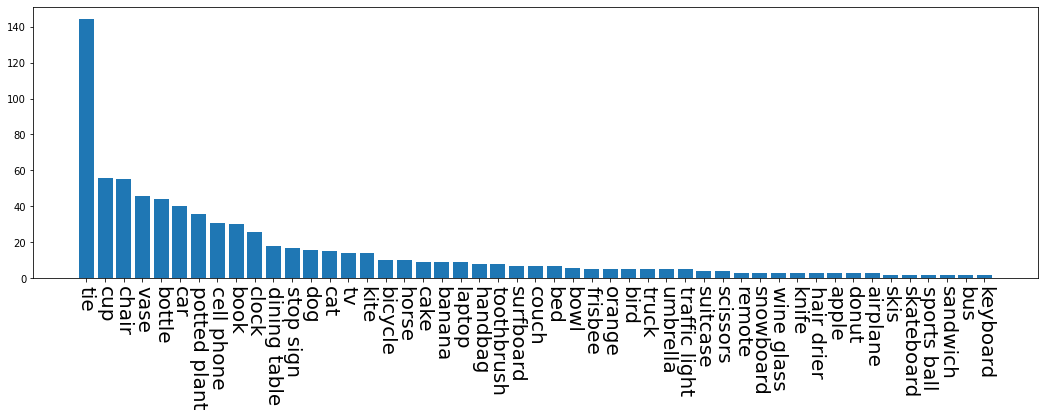

In [189]:
print(unique_gb_objects)
plt.subplots(figsize=(18,5))
plt.bar(unique_gb_objects.head(50).tail(49)["obj_name"], unique_gb_objects.head(50).tail(49)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

**Stany Zjednoczone**

In [190]:
us_objects = us_data["obj_names"].apply(pd.Series, 1).stack()
us_objects.index = us_objects.index.droplevel(-1)
us_objects.name = "obj_name"

us_objects = us_objects.to_frame()
unique_us_objects = us_objects["obj_name"].value_counts() #
unique_us_objects = unique_us_objects.rename_axis("obj_name").reset_index(name="count")
unique_us_objects.describe()

,count
count,76.000000
mean,106.407895
std,679.209328
min,1.000000
25%,4.750000
50%,11.500000
75%,31.250000
max,5937.000000


          obj_name  count
0           person   5937
1              tie    291
2              car    135
3           bottle    117
4             book    117
..             ...    ...
71  baseball glove      2
72           zebra      2
73        broccoli      2
74           sheep      1
75   parking meter      1

[76 rows x 2 columns]


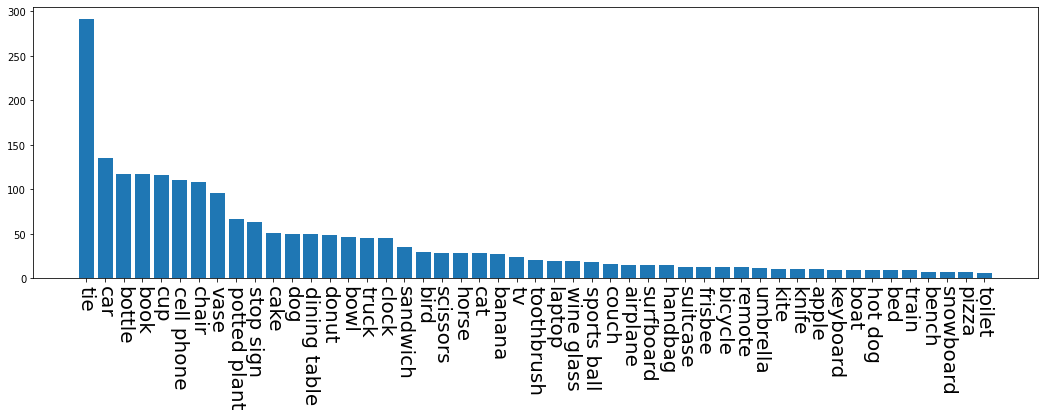

In [191]:
print(unique_us_objects)
plt.subplots(figsize=(18,5))
plt.bar(unique_us_objects.head(50).tail(49)["obj_name"], unique_us_objects.head(50).tail(49)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

**Razem**

In [192]:
objects = pd.concat([gb_objects, us_objects])

unique_objects = objects["obj_name"].value_counts() #
unique_objects = unique_objects.rename_axis("obj_name").reset_index(name="count")
unique_objects.describe()

,count
count,76.000000
mean,159.486842
std,1051.767547
min,1.000000
25%,6.000000
50%,16.500000
75%,39.250000
max,9191.000000


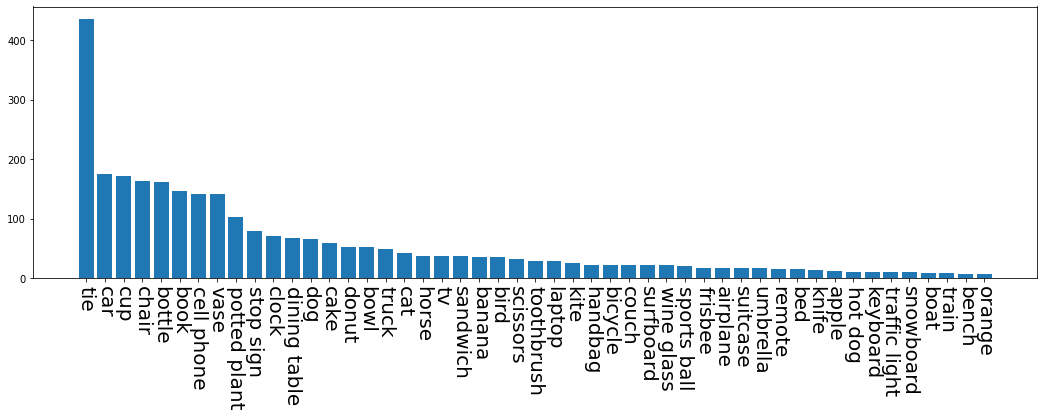

In [193]:
plt.subplots(figsize=(18,5))
plt.bar(unique_objects.head(50).tail(49)["obj_name"], unique_objects.head(50).tail(49)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

Na wykresach można zauważyć, że rozkłady poszczególnych klas w obu zbiorach są
zbliżone do siebie. Kolejnymi najczęściej występującymi obiektami na obrazach
są **tie**, **car**, **cup**, jednak najczęściej pojawia się na nich osoba.
Podobnie można zauważyć, że takie przedmioty często pojawiają się na teledyskach
piosenek, stąd pewnie także występują na obrazach przypisanych do nich.


Poniżej 3 wykresy przedstawiają rozkład klas obiektów, który został pomnożony
przez liczby wystąpień poszczególnych filmów w zbiorze danych. Podobnie
jak na poprzednich wykresach została pominięta klasa **person**.

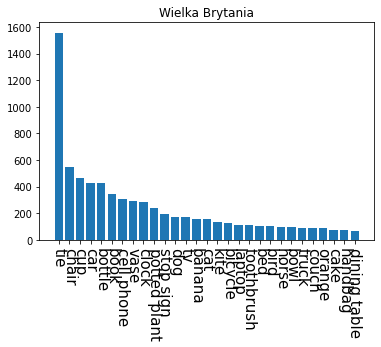

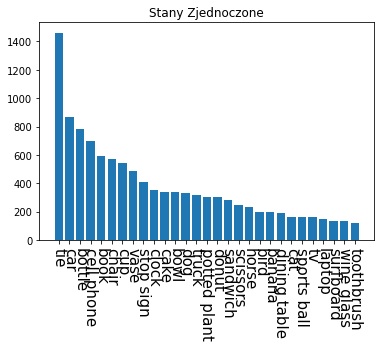

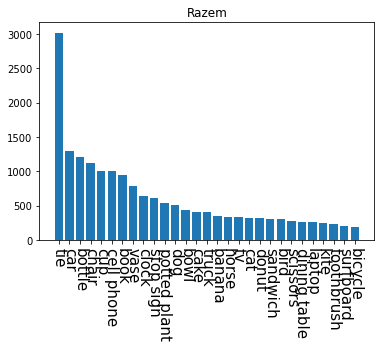

In [262]:
data_sets = [gb_data, us_data, videos_data]
names = ["Wielka Brytania", "Stany Zjednoczone", "Razem"]
for df, name in zip(data_sets, names):
    all_objects = df.explode("obj_names")
    grouped = all_objects.groupby("obj_names")["count"].sum().rename_axis("obj_name").reset_index(name="count")
    grouped = grouped.sort_values(by="count", ascending=False).head(30).tail(29) # TO EXCLUDE PERSON
    plt.bar(np.arange(len(grouped)), grouped["count"])
    plt.title(name)
    plt.xticks(np.arange(len(grouped)),grouped["obj_name"] ,rotation=270, fontsize=15)
    plt.show()



### Rozkład wartości *score*

**Wielka brytania**

In [195]:
gb_scores = gb_data["obj_scores"].apply(pd.Series, 1).stack()
gb_scores.index = gb_scores.index.droplevel(-1)
gb_scores.name = "obj_score"

gb_scores.describe()

count    4034.000000
mean        0.744076
std         0.137273
min         0.500088
25%         0.623234
50%         0.753278
75%         0.865211
max         0.987154
Name: obj_score, dtype: float64

<AxesSubplot:>

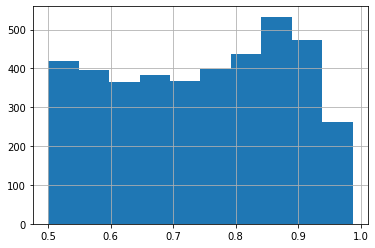

In [75]:
gb_scores.hist()

**Stany Zjednoczone**

In [196]:
us_scores = us_data["obj_scores"].apply(pd.Series, 1).stack()
us_scores.index = us_scores.index.droplevel(-1)
us_scores.name = "obj_score"

us_scores.describe()

count    8087.000000
mean        0.740462
std         0.139954
min         0.500088
25%         0.614561
50%         0.749431
75%         0.866094
max         0.995435
Name: obj_score, dtype: float64

<AxesSubplot:>

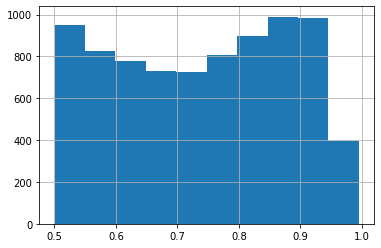

In [77]:
us_scores.hist()

**Razem**

In [197]:
scores = pd.concat([gb_scores, us_scores])

scores.describe()

count    12121.000000
mean         0.741664
std          0.139072
min          0.500088
25%          0.618023
50%          0.750699
75%          0.865448
max          0.995435
Name: obj_score, dtype: float64

<AxesSubplot:>

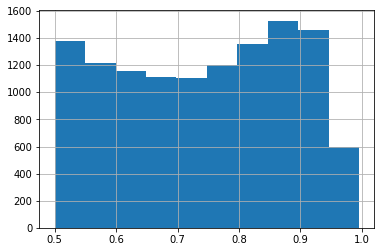

In [198]:
scores.hist()

Patrząc na rozkłady, można zauważyć dwa piki na wykresach, jeden w okolicach
0.5 a drugi w okolicach 0.9. Prawdopodobnie można było by zwiększyć próg odcięcia
do okolic 0.7, aby odrzucić mniej pewnie obserwacje. Zmiana tego parametru,
pozwoliłaby wykluczyć obiekty, których wartości *score* są skumulowane
w okolicach 0.5.

### Emocje

Kolejnym procesem jakiemu zostały poddane obrazy była ekstrakcja emocji
ludzi, znajdujących się na nich. Poniżej znajdują się rozkłady liczb
pojawiających się na obrazach wraz z wykresami.


**Wielka brytania**

In [199]:
gb_emotions = gb_data["emotions"].apply(pd.Series, 1).stack()
gb_emotions.index = gb_emotions.index.droplevel(-1)
gb_emotions.name = "emotion"

gb_emotions = gb_emotions.to_frame()
unique_gb_emotions = gb_emotions["emotion"].value_counts() #
unique_gb_emotions = unique_gb_emotions.rename_axis("emotion").reset_index(name="count")
unique_gb_emotions.describe()

,count
count,7.000000
mean,269.714286
std,320.338214
min,2.000000
25%,63.500000
50%,147.000000
75%,437.500000
max,737.000000


    emotion  count
0     happy    737
1   neutral    728
2      fear    147
3       sad    147
4     angry     79
5  surprise     48
6   disgust      2


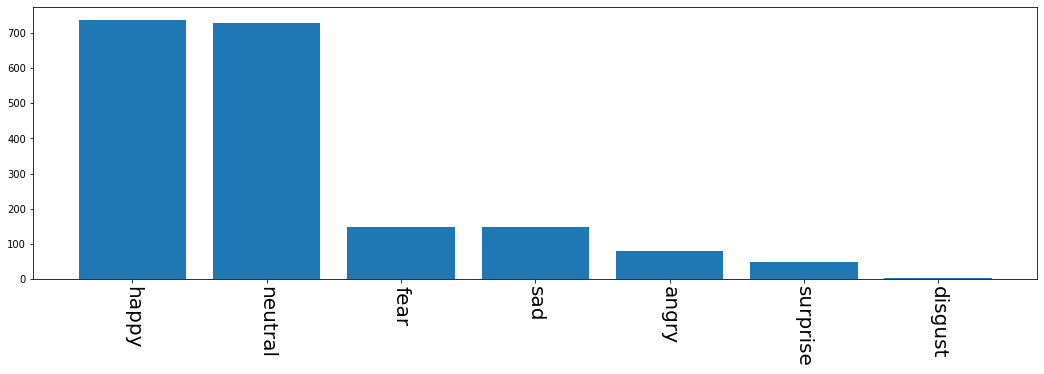

In [200]:
print(unique_gb_emotions)
plt.subplots(figsize=(18,5))
plt.bar(unique_gb_emotions.head(50)["emotion"], unique_gb_emotions.head(50)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

**Stany Zjednoczone**

In [201]:
us_emotions = us_data["emotions"].apply(pd.Series, 1).stack()
us_emotions.index = us_emotions.index.droplevel(-1)
us_emotions.name = "emotion"

us_emotions = us_emotions.to_frame()
unique_us_emotions = us_emotions["emotion"].value_counts() #
unique_us_emotions = unique_us_emotions.rename_axis("emotion").reset_index(name="count")
unique_us_emotions.describe()

,count
count,7.000000
mean,548.285714
std,637.360368
min,10.000000
25%,158.500000
50%,280.000000
75%,812.500000
max,1606.000000


    emotion  count
0     happy   1606
1   neutral   1319
2      fear    306
3       sad    280
4     angry    171
5  surprise    146
6   disgust     10


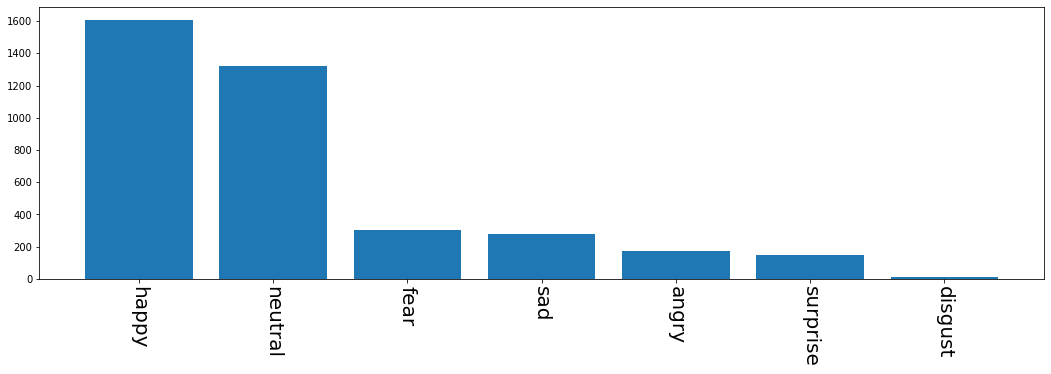

In [202]:
print(unique_us_emotions)
plt.subplots(figsize=(18,5))
plt.bar(unique_us_emotions.head(50)["emotion"], unique_us_emotions.head(50)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

**Razem**

In [203]:
emotions = pd.concat([gb_emotions, us_emotions])

unique_emotions = emotions["emotion"].value_counts() #
unique_emotions = unique_emotions.rename_axis("emotion").reset_index(name="count")
unique_emotions.describe()

,count
count,7.000000
mean,818.000000
std,956.016736
min,12.000000
25%,222.000000
50%,427.000000
75%,1250.000000
max,2343.000000


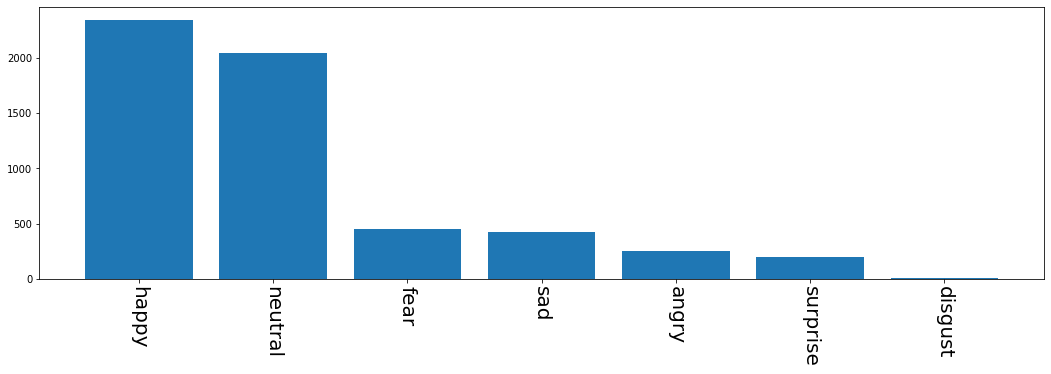

In [204]:
plt.subplots(figsize=(18,5))
plt.bar(unique_emotions.head(50)["emotion"], unique_emotions.head(50)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

Na wykresach można zauważyć znaczną przewagę emocji **happy** i **neutral**.
Emocje o złym wydźwięku, raczej nie są popularne w zbiorach danych.
Można zatem wnioskować, że filmy z sekcji trending raczej łaczą się
z pozytywnymi emocjami lun są neutralne.



Poniżej 3 wykresy przedstawiają rozkład emocji,
który został pomnożony przez liczby wystąpień poszczególnych filmów w zbiorze danych.

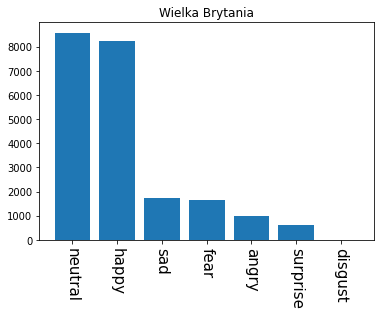

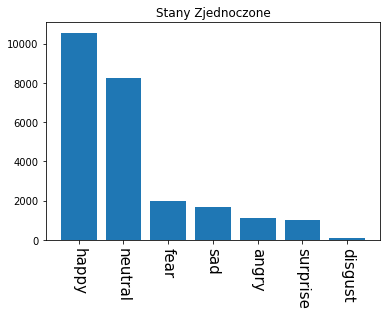

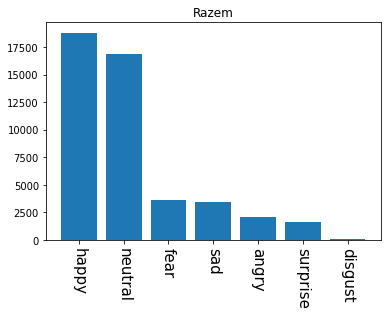

In [205]:
data_sets = [gb_data, us_data, videos_data]
names = ["Wielka Brytania", "Stany Zjednoczone", "Razem"]
for df, name in zip(data_sets, names):
    all_objects = df.explode("emotions")
    grouped = all_objects.groupby("emotions")["count"].sum().rename_axis("emotion").reset_index(name="count")
    grouped = grouped.sort_values(by="count", ascending=False).tail(30).head(29) # TO EXCLUDE PERSON
    plt.bar(np.arange(len(grouped)), grouped["count"])
    plt.title(name)
    plt.xticks(np.arange(len(grouped)),grouped["emotion"] ,rotation=270, fontsize=15)
    plt.show()


Na wykresach można zauważyć jeszcze większą przewagę emocji **happy** i **neutral**


### Ekstrakcja tekstu z obrazów

Poniżej przedstawione są podstawowe statystyki oraz
50 najczęściej występujących obrazów dla poszczególnych zbiorów.
Teksty zostały poddane tej samej tokenizacji co atrybuty
tekstowe w poprzednim etapie.

Dodatkowo w celu odfiltrowanie
błędnie odczytanych tekstów przefiltrowano uzyskane tokeny
i pozostawiono tylko te występujące w słowniku języka angielskiego
biblioteki **nltk**.

**Wielka brytania**


3272
Nan: 2569
          words  count
0            ee     82
1            ae     67
2          vevo     38
3            oe     37
4            es     35
...         ...    ...
2028        gap      1
2029   gamespot      1
2030  gamerscor      1
2031   gameplay      1
2032        zzz      1

[2033 rows x 2 columns]


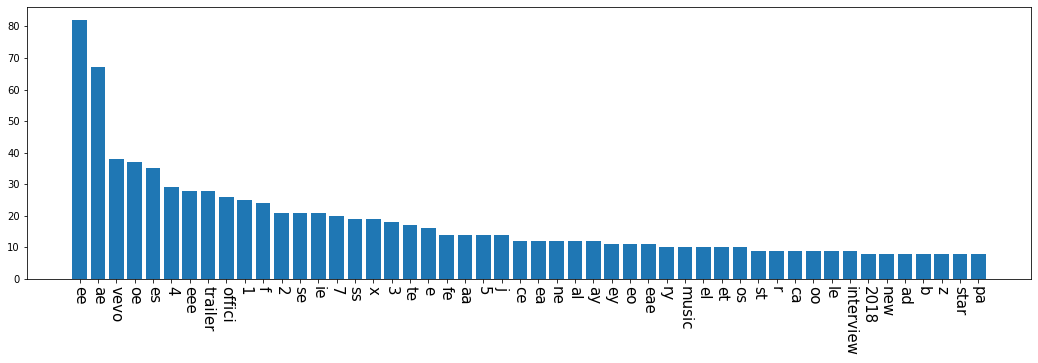

In [206]:
words_counts = tokenize(os.path.join("..", "words" , "gb_ocr_text_words.csv"), gb_data, os.path.join("tokenized", "gb_tokenized_ocr_text.json"))
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

Przefiltrowanie przez słownik nltk

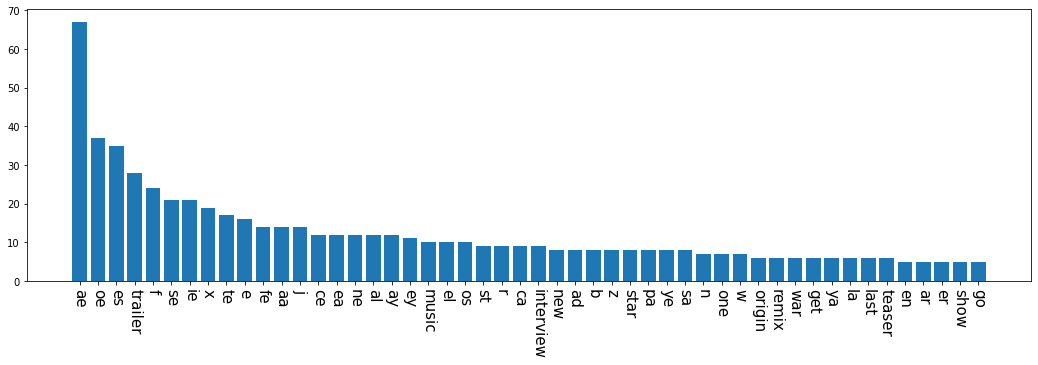

In [207]:
in_words = words_counts.apply(filter_words, axis=1)
words_counts = words_counts[in_words]
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

**Stany Zjednoczone**


6354
Nan: 4891
         words  count
0           ee    178
1           ae    134
2            4    115
3            7     69
4           es     65
...        ...    ...
3562  ghaimber      1
3563     ghost      1
3564       gia      1
3565    gibson      1
3566      lamp      1

[3567 rows x 2 columns]


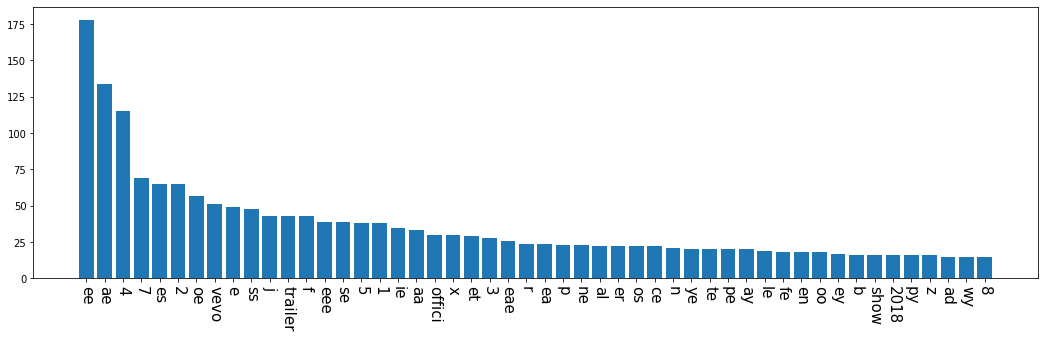

In [208]:
words_counts = tokenize(os.path.join("..", "words", "us_ocr_text_words.csv"), us_data, os.path.join("tokenized", "us_tokenized_ocr_text.json"))
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

Przefiltrowanie przez słownik nltk

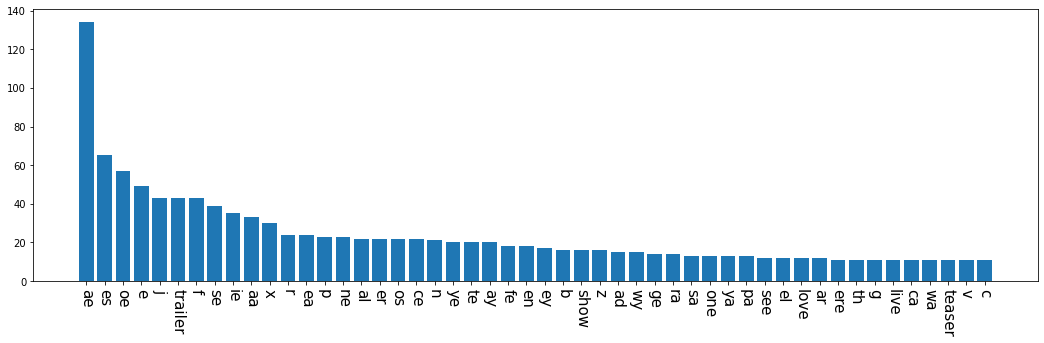

In [209]:
in_words = words_counts.apply(filter_words, axis=1)
words_counts = words_counts[in_words]
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

**Razem**


9626
Nan: 7460
        words  count
0          ee    260
1          ae    201
2           4    144
3          es    100
4          oe     94
...       ...    ...
4404     hair      1
4405      hal      1
4406     hala      1
4407  halfpip      1
4408      zzz      1

[4409 rows x 2 columns]


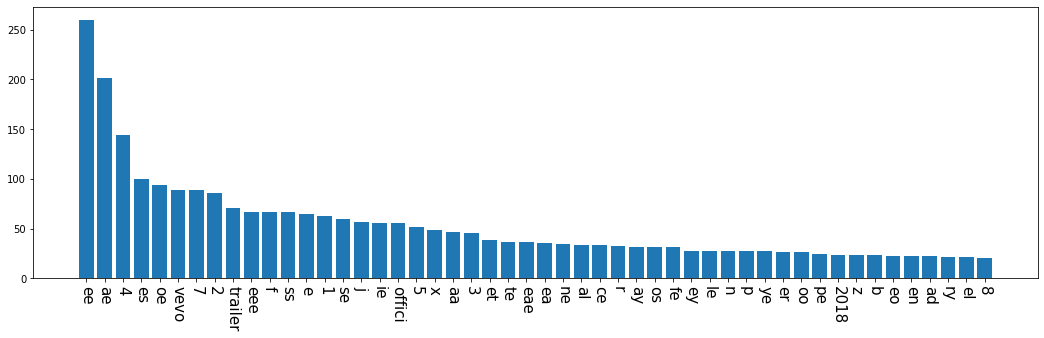

In [210]:
words_counts = tokenize(os.path.join("..", "words", "ocr_text_words.csv"), videos_data, os.path.join("tokenized", "tokenized_ocr_text.json"))
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

Przefiltrowanie przez słownik nltk

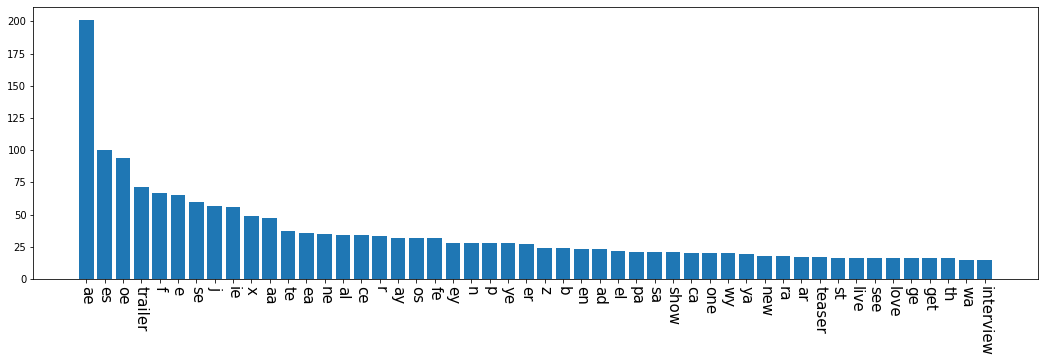

In [211]:
in_words = words_counts.apply(filter_words, axis=1)
words_counts = words_counts[in_words]
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

Na wykresach ponownie można zauważyć, że dość często pojawiają się słowa
kluczowe wskazujące na teledyski piosenek lub zwiastuny filmów. W śród
często występujących wyrazów występują także tokeny **star** i **war**, które
prawdopodobnie pochodzą z tytułuy filmu Star Wars. W przypadku zbioru
ze Stanów zjednoczonych można także zauważyć token 2018, czyli rok z którego
początku filmy pochodzą (w większości) lub zostały filmami z sekcji trending.


### Kolory

W tym etapie zostały wyekstrachowane kolory z obrazów. Ekstrakcja
polegała na znalezieniu najbliższego z 256 kolorów przy pomocy
odległości Euklidesowej, a następnie zwrócenie 5 najszęściej występujących
kolorów na obrazie.

**Wielka brytania**

In [249]:
from imgprocessing.colors_extractor import tuple_to_hex
from colors import colors_dict


gb_colors = gb_data.explode("colors")
gb_colors["color"] = gb_colors["colors"].apply(lambda x: x if isinstance(x, float) else str(x[0][0]))
gb_colors["color_counts"] = gb_colors["colors"].apply(lambda x: x if isinstance(x, float) else x[1])

gb_colors = gb_colors["color"].apply(pd.Series, 1).stack()
print(gb_colors.head())
gb_colors.index = gb_colors.index.droplevel(-1)
gb_colors.name = "color"

gb_colors = gb_colors.to_frame()
unique_gb_colors = gb_colors["color"].value_counts() #
unique_gb_colors = unique_gb_colors.rename_axis("color").reset_index(name="count")
unique_gb_colors.describe()

0  0      (175, 95, 95)
   0     (175, 135, 95)
   0      (135, 95, 95)
   0    (158, 158, 158)
   0    (178, 178, 178)
dtype: object


,count
count,203.000000
mean,61.231527
std,164.548078
min,1.000000
25%,4.000000
50%,11.000000
75%,40.500000
max,1135.000000


               color  count
0       (28, 28, 28)   1135
1       (18, 18, 18)   1075
2       (38, 38, 38)    981
3       (48, 48, 48)    735
4          (8, 8, 8)    695
..               ...    ...
198  (215, 135, 255)      1
199    (255, 0, 215)      1
200    (128, 128, 0)      1
201   (175, 215, 95)      1
202    (95, 215, 95)      1

[203 rows x 2 columns]


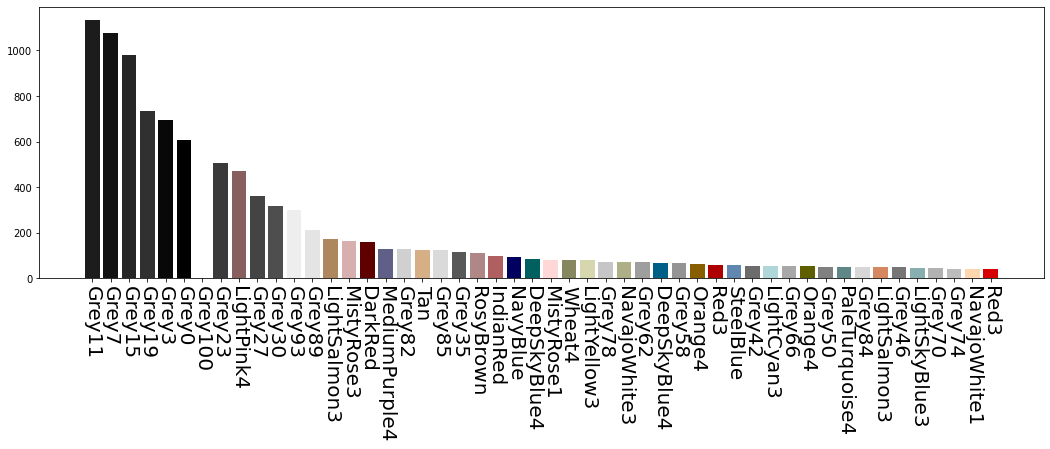

In [251]:
print(unique_gb_colors)
plt.subplots(figsize=(18,5))
colors = [tuple_to_hex(eval(c)) for c in unique_gb_colors.head(50)["color"]]
ticks = [colors_dict[eval(c)] for c in unique_gb_colors.head(50)["color"]]
plt.bar(np.arange(50), unique_gb_colors.head(50)["count"], color=colors)
plt.xticks(np.arange(50), ticks, rotation=270, fontsize=20)
plt.show()

**Stany Zjednoczone**

In [252]:
us_colors = us_data.explode("colors")
us_colors["color"] = us_colors["colors"].apply(lambda x: x if isinstance(x, float) else str(x[0][0]))
us_colors["color_counts"] = us_colors["colors"].apply(lambda x: x if isinstance(x, float) else x[1])

us_colors = us_colors["color"].apply(pd.Series, 1).stack()
print(us_colors.head())
us_colors.index = us_colors.index.droplevel(-1)
us_colors.name = "color"

us_colors = us_colors.to_frame()
unique_us_colors = us_colors["color"].value_counts() 
unique_us_colors = unique_us_colors.rename_axis("color").reset_index(name="count")
unique_us_colors.describe()

0  0       (0, 95, 215)
   0       (18, 18, 18)
   0    (255, 215, 215)
   0    (215, 215, 175)
   0       (28, 28, 28)
dtype: object


,count
count,236.000000
mean,107.923729
std,294.684531
min,1.000000
25%,5.000000
50%,18.500000
75%,62.250000
max,2085.000000


               color  count
0       (28, 28, 28)   2085
1       (18, 18, 18)   1968
2       (38, 38, 38)   1769
3       (48, 48, 48)   1385
4    (255, 255, 255)   1385
..               ...    ...
231    (135, 215, 0)      1
232   (255, 95, 215)      1
233    (135, 255, 0)      1
234  (215, 135, 255)      1
235   (215, 255, 95)      1

[236 rows x 2 columns]


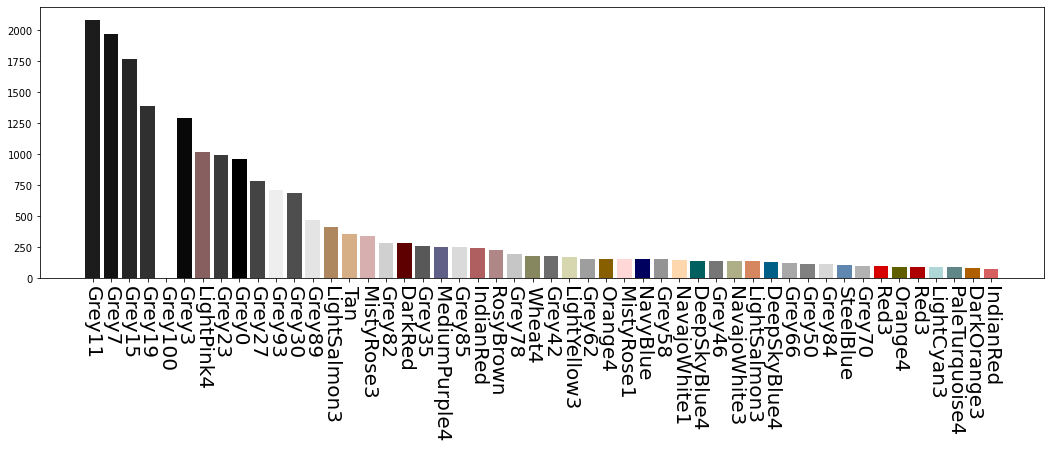

In [253]:
print(unique_us_colors)
plt.subplots(figsize=(18,5))
colors = [tuple_to_hex(eval(c)) for c in unique_us_colors.head(50)["color"]]
ticks = [colors_dict[eval(c)] for c in unique_us_colors.head(50)["color"]]
plt.bar(np.arange(50), unique_us_colors.head(50)["count"], color=colors)
plt.xticks(np.arange(50), ticks, rotation=270, fontsize=20)
plt.show()

**Razem**

In [257]:
colors = pd.concat([gb_data, us_data])

all_colors = colors.explode("colors")
all_colors["color"] = all_colors["colors"].apply(lambda x: x if isinstance(x, float) else str(x[0][0]))
all_colors["color_counts"] = all_colors["colors"].apply(lambda x: x if isinstance(x, float) else x[1])

all_colors = all_colors["color"].apply(pd.Series, 1).stack()
print(all_colors.head())
all_colors.index = all_colors.index.droplevel(-1)
all_colors.name = "color"

all_colors = all_colors.to_frame()
unique_all_colors = all_colors["color"].value_counts() #
unique_all_colors = unique_all_colors.rename_axis("color").reset_index(name="count")
unique_all_colors.describe()

0  0      (175, 95, 95)
   0     (175, 135, 95)
   0      (135, 95, 95)
   0    (158, 158, 158)
   0    (178, 178, 178)
dtype: object


,count
count,240.000000
mean,157.916667
std,444.644168
min,1.000000
25%,6.000000
50%,24.500000
75%,89.750000
max,3220.000000


               color  count
0       (28, 28, 28)   3220
1       (18, 18, 18)   3043
2       (38, 38, 38)   2750
3       (48, 48, 48)   2120
4          (8, 8, 8)   1990
..               ...    ...
235     (0, 255, 95)      1
236   (95, 255, 215)      1
237    (215, 255, 0)      1
238  (135, 255, 175)      1
239    (135, 255, 0)      1

[240 rows x 2 columns]


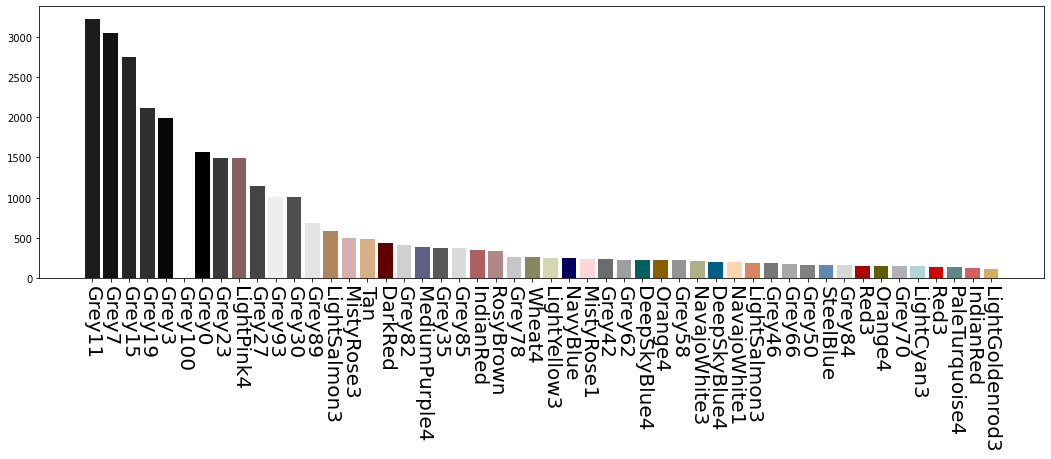

In [258]:
print(unique_all_colors)
plt.subplots(figsize=(18,5))
colors = [tuple_to_hex(eval(c)) for c in unique_all_colors.head(50)["color"]]
ticks = [colors_dict[eval(c)] for c in unique_all_colors.head(50)["color"]]
plt.bar(np.arange(50), unique_all_colors.head(50)["count"], color=colors)
plt.xticks(np.arange(50), ticks, rotation=270, fontsize=20)
plt.show()

Przemnożone przez ilość pikseli danego koloru

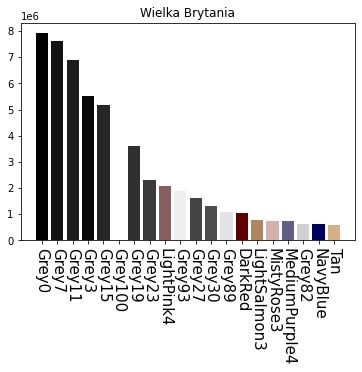

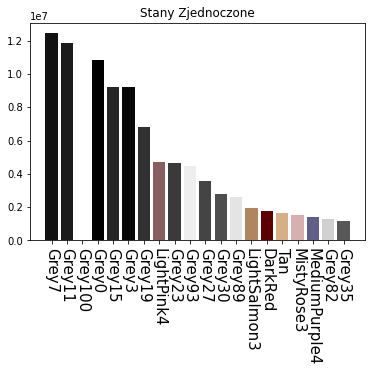

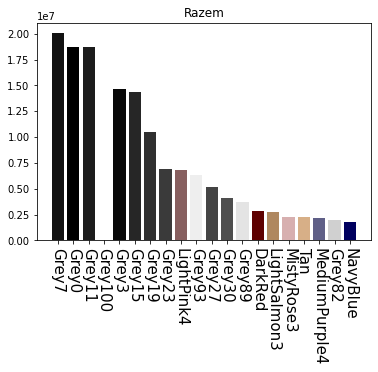

In [275]:
data_sets = [gb_data, us_data, videos_data]
names = ["Wielka Brytania", "Stany Zjednoczone", "Razem"]
for df, name in zip(data_sets, names):
    df_colors = df.explode("colors")
    df_colors["color"] = df_colors["colors"].apply(lambda x: x if isinstance(x, float) else str(x[0][0]))
    df_colors["color_counts"] = df_colors["colors"].apply(lambda x: x if isinstance(x, float) else x[1])


    grouped = df_colors.groupby("color")["color_counts"].sum().rename_axis("color").reset_index(name="count")
    grouped = grouped.sort_values(by="count", ascending=False).head(20) # TO EXCLUDE PERSON
    colors = [tuple_to_hex(eval(c)) for c in grouped["color"]]
    ticks = [colors_dict[eval(c)] for c in grouped["color"]]
    plt.bar(np.arange(len(grouped)), grouped["count"], color=colors)
    plt.title(name)
    plt.xticks(np.arange(len(grouped)),ticks ,rotation=270, fontsize=15)
    plt.show()

Na wykresach można zauważyć, że najczęściej występującymi
kolorami są odcienie szarości/czarnego. Jest to dość dużym zaskoczeniem,
ponieważ wcześniej zauważono raczej pozytywne nastawienie ludzi znajdujących
się na obrazach, a wymienione kolory są kojarzone bardziej z negatywnym/smutnym
wydźwiękiem.

# Podsumowanie
Przeanalizowano wiele różnych atrybutów miniaturek do popularnych filmów z których na pewno część może zostać użyta jako atrybuty pomagające rozróżnić film który mógł zostać trending od tego który nie został, choć na pewno część wykrytch zalezności jest charakterystyczna dla większej ilości kontentu na platformie YouTube.

Z ciekwszych obserwacji, które były potwierdzane przez różne rodzaje analizy można stworzyć sobie wyobrażenie najczęsciej występujących rodzaji obrazków. 
Bardzo często na miniaturce przedstawiani byli ludzie, najczęściej ich sylwetka znajdowała się w centralnej części obrazu, a wyraz ich twarzy był uśmiechnięty bądź neutralny. Najbardziej popularnym napisem był znak wodny firmy "vevo", który zawsze znajdował się tym samym miejscu. Kolorystycznie dominują w miniaturkach kolory ciemne w odcieniu niebieskim. Centrum obrazków jest z zasady elementem najjaśniejszym, w którym występuje największa złożoność i rożnorodność, szczególnie w filmach z US. Najmniej działo się na krawędziach obrazku, gdzie również kolory były często odrobine ciemniejsze. Filmy pochądzące ze Stanów Zjednoczonych były średnio jaśniejsze i zawierały więcej elementów, co zwiększało ich różnorodność kolorystyczną.

# TODO analiza kolorów na hsv i odcięcie tła
# TODO rozkład hsv -lepsze postrzeganie kolorów przez człowieka